# HMM to estimate Funnel position

## Import libraries and constants

In [35]:
# Import Constants
import config.CONSTANTS_HMM as consts

# Project libraries
import src.hmm_package.generate_hmm
from src.hmm_package.generate_hmm import *
import src.plot_and_print_info.plots_and_print_info
from src.plot_and_print_info.plots_and_print_info import *

# Built in libraries
import numpy as np
import importlib

In [44]:
importlib.reload(src.hmm_package.generate_hmm)
from src.hmm_package.generate_hmm import *
importlib.reload(consts)
from config.CONSTANTS_HMM import *
importlib.reload(src.plot_and_print_info.plots_and_print_info)
from src.plot_and_print_info.plots_and_print_info import *

In [45]:
# Store constants
cm = {}
for k, v in consts.__dict__.items():
    if not k.startswith('__'):
        cm[k] = v

## Compute Observation and Adstock

To study the behaviour of the Hidden Markov Model, we generate a random exposition of the users to some campaigns. The parameters for the simulation are in config/CONSTANTS_HMM.py

In [38]:
# Generate Test observation
observation = simulate_observations(cm)

# Compute Adstock
adstock = compute_adstock(cm, observation=observation)

## Real HMM to Estimate

In [39]:
# Generate the distributions to build the Real HMM.
# The parameter MU, describing the behaviour of a user unexposed, has been fitted in a separate notebook and is considered known.
#NB The variable STATES_ARE_OBSERVABLE is set in config/execution_parameters.
hmm_distributions = generate_hmm_distributions(cm, initial_state_prob_vector= INITIAL_STATE_PROB,
                                               click_prob=tf.constant(CLICK_PROB),
                                               adstock=adstock)

# Create Real HMM to fit
real_hmm = tfd.HiddenMarkovModel(
    initial_distribution=hmm_distributions['initial_distribution'],
    transition_distribution=hmm_distributions['transition_distribution'],
    observation_distribution=hmm_distributions['observation_distribution'],
    time_varying_transition_distribution=True,
    num_steps=time+1
)

# Sample emissions
emission_real = real_hmm.sample().numpy()

### Visualize the Real HMM

Percentage of conversion is: 35.76%.


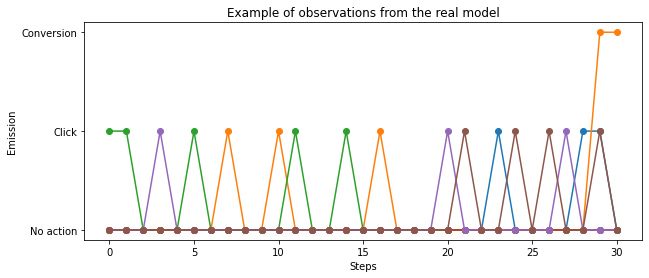

In [40]:
# Count conversions from sampled data

tot_conversions = count_conversions(emission_real)
plot_sample_emissions(real_hmm)

## Build and fit the model starting from a random initializer

In [47]:
inverse_sigmoid = lambda x: np.log(x/(1-x))
# Now try to fit the model sampled from the real parameters.
initializer={
    'MU': tf.keras.initializers.Constant([ -3, -1., -5 ]),
    'BETA': tf.keras.initializers.Constant([ 1., 0., 0.5, 0.5, 0., 1.]),
    'INIT_PROB': tf.keras.initializers.Constant(inverse_sigmoid(0.75)), #
    'CLICK_PROB': tf.keras.initializers.Constant(inverse_sigmoid(0.25))},
model = build_hmm_to_fit_beta(cm, initializer=initializer )

compiler = CompilerInfoBeta(cm, LR_EXPONENTIAL_DECAY)
model.compile(
    loss = compiler.loss,
    optimizer = compiler.optimizer,
    run_eagerly = True
)
history = fit_model(cm, model, adstock, emission_real)
save_result(cm, model, adstock, emission_real, initializer)

plot_loss_decay(model)

Mu: [-3.0, -1.0, -5.0] Beta: [1.0, 0.0, 0.5, 0.5, 0.0, 1.0] Init Prob: [<tf.Tensor: shape=(), dtype=float32, numpy=0.75>] Click Prob: [<tf.Tensor: shape=(), dtype=float32, numpy=0.25000003>]
Epoch 1/200
10/10 [==============================] - 11s 1s/step - loss: 6104.5366
Mu: [-3.009883, -0.99002373, -5.009989] Beta: [0.99006146, 0.0, 0.49000594, 0.4901493, 0.0, 0.99001485] Init Prob: [<tf.Tensor: shape=(), dtype=float32, numpy=0.75184286>] Click Prob: [<tf.Tensor: shape=(), dtype=float32, numpy=0.25163758>]
Epoch 2/200
10/10 [==============================] - 9s 888ms/step - loss: 6065.1465
Mu: [-3.0195503, -0.9802063, -5.0198593] Beta: [0.98028195, 0.0, 0.48011464, 0.48049983, 0.0, 0.98014265] Init Prob: [<tf.Tensor: shape=(), dtype=float32, numpy=0.75360084>] Click Prob: [<tf.Tensor: shape=(), dtype=float32, numpy=0.25325388>]
Epoch 3/200
10/10 [==============================] - 12s 1s/step - loss: 6028.9126
Mu: [-3.0287337, -0.9707068, -5.0294933] Beta: [0.9707741, 0.0, 0.47047988

ValueError: This test already exists in hmm_test_fitting.data!

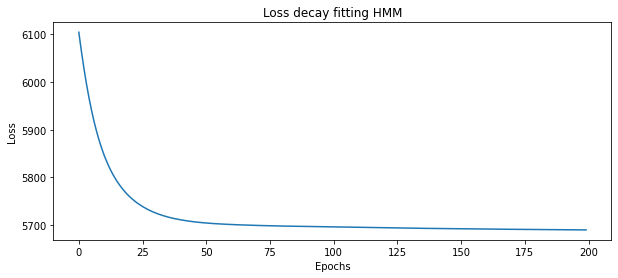

In [48]:
plot_loss_decay(model)

In [ ]:
# Compute the average difference between the real transition matrix and the fitted one
matrix_diff = lambda usr: tf.reduce_sum(make_transition_matrix(cm, model.weights[0], model.weights[1], adstock[usr:usr+1]) - make_transition_matrix(cm, MU,BETA, adstock[usr:usr+1]), axis=1)/30
avg_diff = sum(matrix_diff(usr) for usr in range(N_users))/N_users